<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('max_info_columns',999)
import warnings; warnings.simplefilter('ignore')

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from patsy import dmatrices
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,ShuffleSplit, train_test_split
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression,f_classif
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.metrics import confusion_matrix
import scipy.stats as st

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
#### The size of the lot, lot frontage, garage square footage, basement square footage, total square footage, building type and neighborhood looke like good predictors of price
---
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')


In [3]:
#delete non-residential data
mask = (house['MSZoning'] != 'C (all)')
residential= pd.DataFrame(house[mask])

In [4]:
#checking out the data to look at data types and look for null values
residential.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [5]:
#clean the data by filling in the blank values
#clean the data
#fill in the numeric fields with 0 and either 'None' or 'NA' for the other values
residential['LotFrontage'].fillna(0,inplace = True)
residential['MasVnrType'].fillna('None',inplace = True)
residential['MasVnrArea'].fillna(0,inplace = True)
residential['GarageType'].fillna('NA',inplace =   True)
residential['GarageYrBlt'].fillna(0,inplace = True)
residential['BsmtExposure'].fillna('NA',inplace = True)
residential['Alley'].fillna('NA',inplace = True)
residential['BsmtQual'].fillna('NA',inplace =     True)

residential['BsmtCond'].fillna('NA',inplace =     True)
residential['BsmtFinType1'].fillna('NA',inplace = True)
residential['BsmtFinType2'].fillna('NA',inplace = True)
residential['GarageFinish'].fillna('NA',inplace = True)
residential['GarageQual'].fillna('NA',inplace =   True)
residential['GarageCond'].fillna('NA',inplace =   True)
residential['Electrical'].fillna('SBrkr',inplace = True)

In [6]:
#determine continuous variables that I want to keep
continuous_list = [
'SalePrice',
'LotFrontage', #
'LotArea',
'MasVnrArea',
'TotalBsmtSF',#
'GrLivArea',
'GarageArea', #
'PoolArea',
'TotSF'
]



In [7]:
#combine 1stFlrSF and 2ndFlrSF into TotSF
residential['TotSF']=residential['1stFlrSF']+ residential['2ndFlrSF']

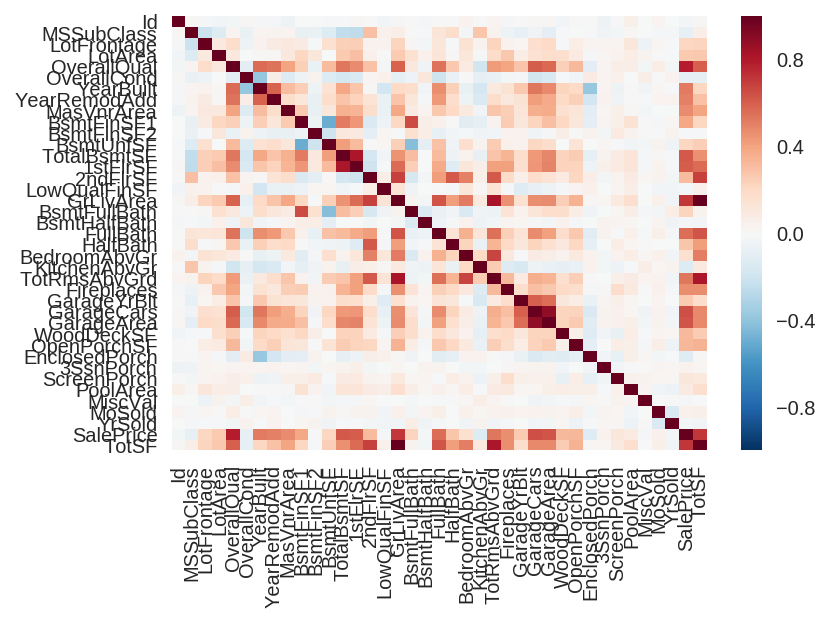

In [8]:
sns.heatmap(residential.corr())

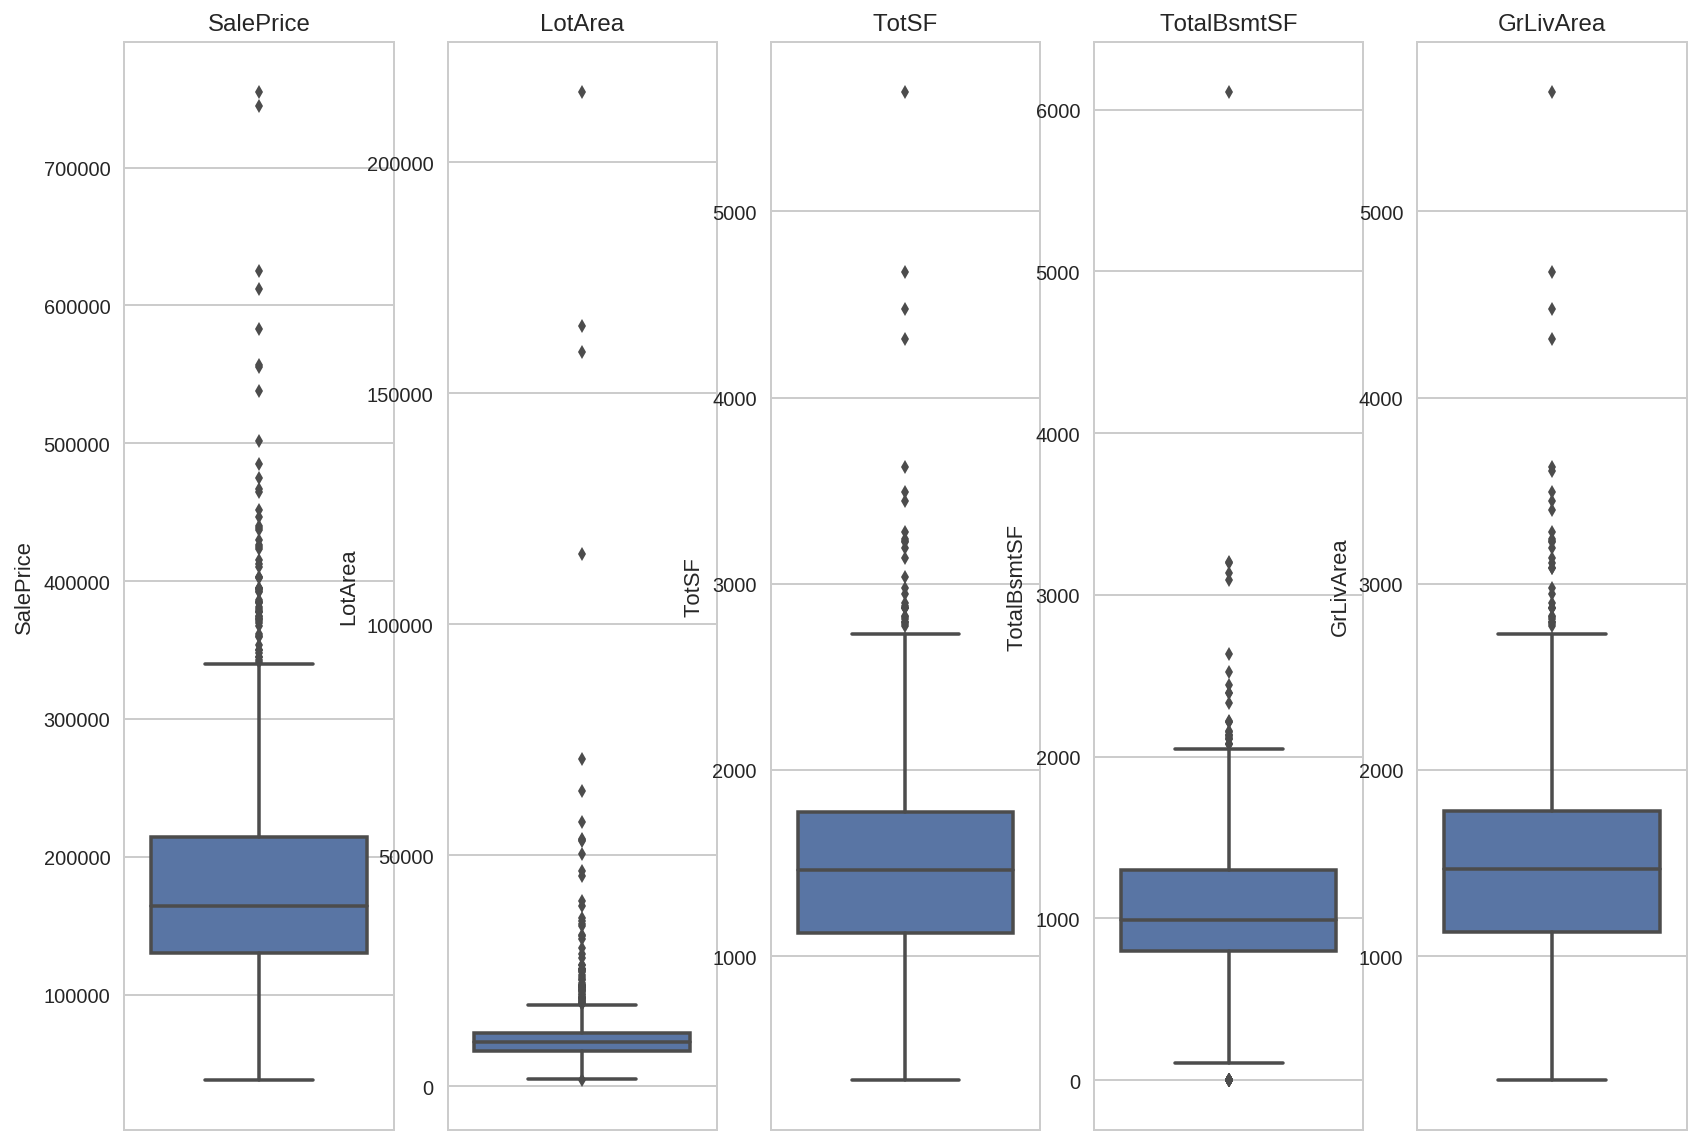

In [9]:
#look for outliers.  Plot some before and after boxplots for outliers
fig = plt.figure(figsize=(14,10))
fig.add_subplot(151)
plt.title("SalePrice")
sns.boxplot(y= residential['SalePrice'])
fig.add_subplot(152)
plt.title("LotArea")
sns.boxplot(y= residential['LotArea'])
fig.add_subplot(153)
plt.title("TotSF")
sns.boxplot(y= residential['TotSF'])
fig.add_subplot(154)
plt.title("TotalBsmtSF")
sns.boxplot(y= residential['TotalBsmtSF'])
fig.add_subplot(155)
plt.title("GrLivArea")
sns.boxplot(y= residential['GrLivArea'])



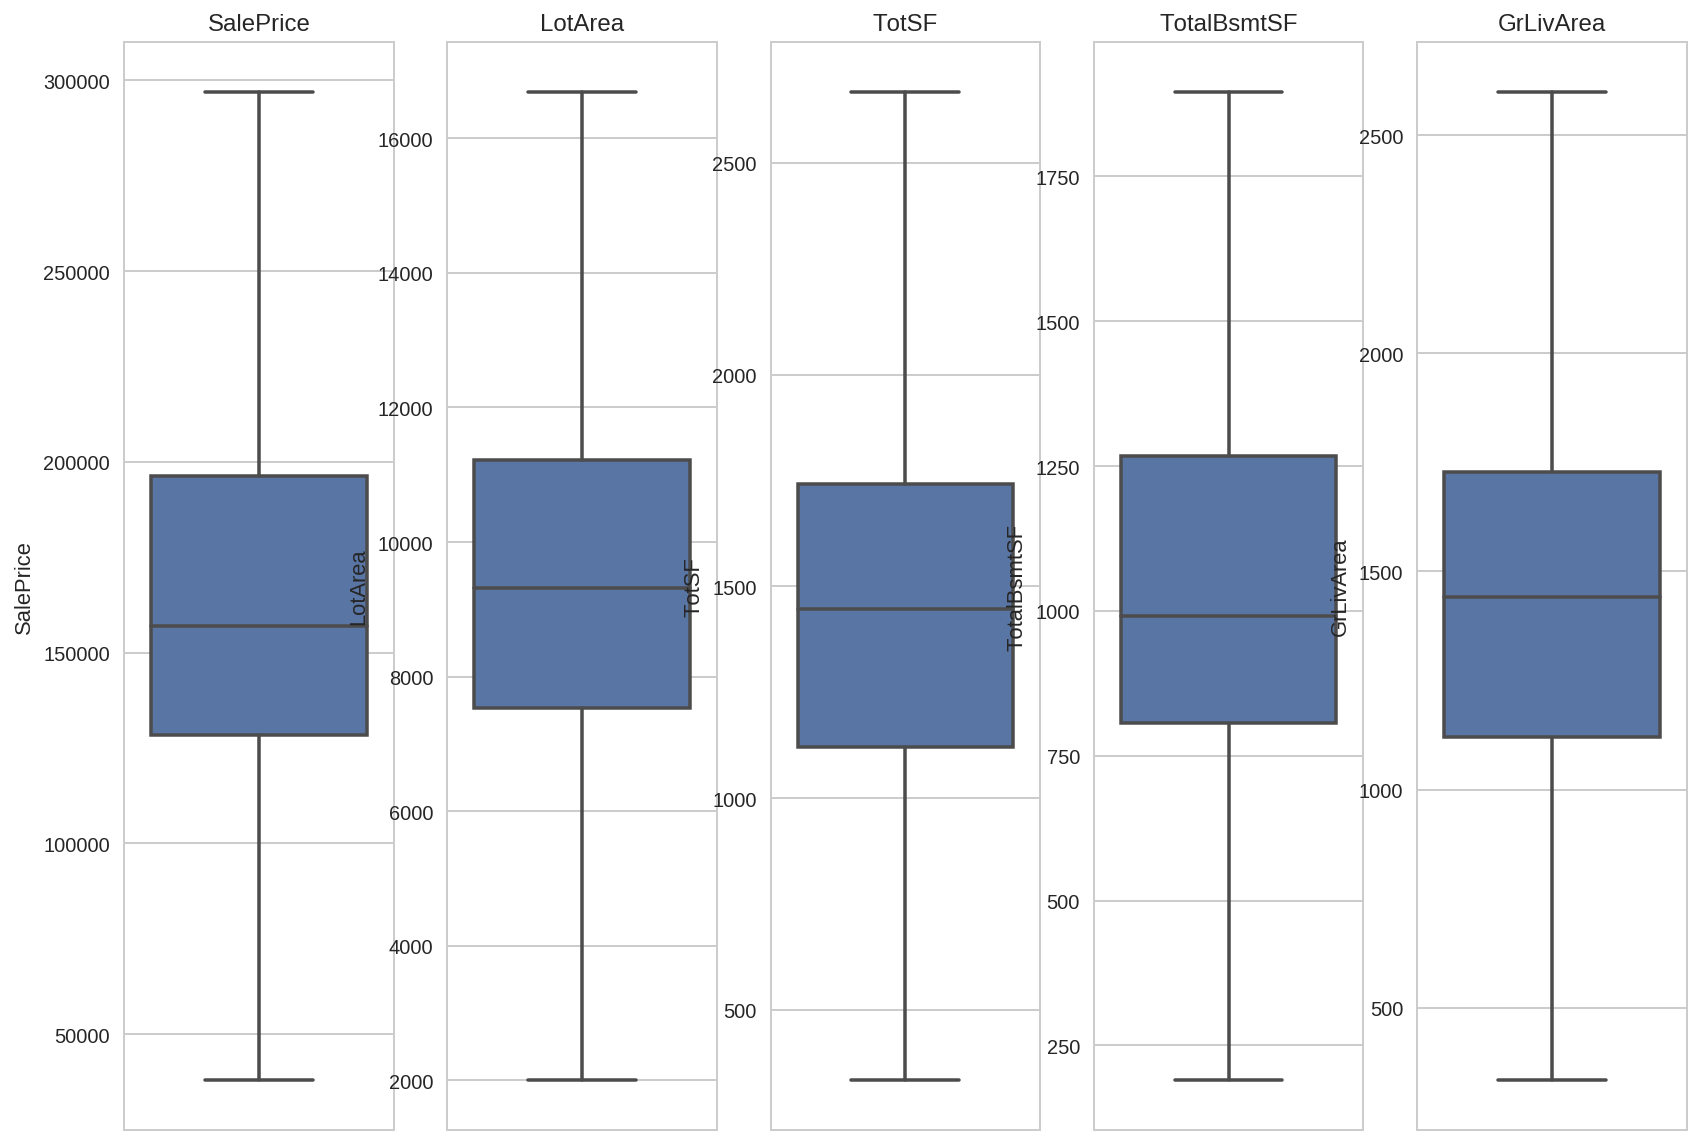

In [10]:
#creating the masks to remove outliers according to boxplot above
mask1 = (residential['SalePrice']<299000)
mask2 = ( (residential['LotArea'] < 16700) & (residential['LotArea'] >2000))
mask3 = (residential['TotSF']<2680)
mask4 = ( (residential['TotalBsmtSF'] < 1900) & (residential['TotalBsmtSF'] > 105))
mask5 = (residential['GrLivArea'] < 2600)

#replotting to check for outliers
fig2 = plt.figure(figsize=(14,10))
fig2.add_subplot(151)
plt.title("SalePrice")
sns.boxplot(y= residential[mask1]['SalePrice'])
fig2.add_subplot(152)
plt.title("LotArea")
sns.boxplot(y= residential[mask2]['LotArea'])
fig2.add_subplot(153)
plt.title("TotSF")
sns.boxplot(y= residential[mask3]['TotSF'])
fig2.add_subplot(154)
plt.title("TotalBsmtSF")
sns.boxplot(y= residential[mask4]['TotalBsmtSF'])
fig2.add_subplot(155)
plt.title("GrLivArea")
sns.boxplot(y= residential[mask5]['GrLivArea'])

In [11]:

#checking out outliers
#trying to get an idea of how many rows are in the outliers
mask1 = (residential['SalePrice']<299000)
mask2 = ( (residential['LotArea'] < 16700) & (residential['LotArea'] >2000))
mask3 = (residential['TotSF']<2680)
mask4 = ( (residential['TotalBsmtSF'] < 1900) & (residential['TotalBsmtSF'] > 105))
mask5 = (residential['GrLivArea'] < 2600)

print('sale price > 299000: {}'.format(residential[~mask1].shape))
print('Lot Area < 2000 or > 16700: {}'.format(residential[~mask2].shape))
print('Total Square Footage > 2680: {}'.format(residential[~mask3].shape))
print('Total Basement Square Footage < 105 or > 1900: {}'.format(residential[~mask4].shape))
print('Total Above Ground living area > 2600: {}'.format(residential[~mask5].shape))
#37 rows for no basement so just going to drop them
#the rest doesn't look too bad so going to drop them too

sale price > 299000: (116, 82)
Lot Area < 2000 or > 16700: (106, 82)
Total Square Footage > 2680: (37, 82)
Total Basement Square Footage < 105 or > 1900: (84, 82)
Total Above Ground living area > 2600: (53, 82)


In [13]:
#Remove the outliers
residential = residential[mask1]
residential = residential[mask2]
residential = residential[mask3]
residential = residential[mask4]
residential = residential[mask5]

In [987]:
#Fixed Features I will use to predict price
fixed_features = [
'Utilities',
'GarageArea',
'MSSubClass',
'MSZoning',
'LotArea',
'Street',
'Alley',
'LotShape',
'LandContour',
'LotFrontage',
'LotConfig',
'Neighborhood',
'Condition1',
'Condition2',
'BldgType',
'HouseStyle',
'YearBuilt',
'YearRemodAdd',
'RoofStyle',
'Foundation',
'BsmtQual',
'BsmtExposure',
'TotalBsmtSF',
'TotSF',
'GrLivArea',
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'Fireplaces',
'GarageType',
'GarageYrBlt',
'GarageCars',
'MoSold',
'YrSold',
'SaleType',
'SaleCondition',
'SalePrice'
]

In [707]:
#renovatable Features

Renovatable_features = [
'OverallQual',
'OverallCond',
'RoofMatl',
'MasVnrArea',
'ExterQual',
'ExterCond',
'Exterior1st',
'Exterior2nd',
'MasVnrType',
'BsmtCond',
'BsmtFinType1',
'BsmtFinType2',
'BsmtFinSF1',
'BsmtUnfSF',
'Heating',
'HeatingQC',
'CentralAir',
'Electrical',
'KitchenQual',
'Functional',
'GarageFinish',
'GarageQual',
'GarageCond',
'PavedDrive',
'WoodDeckSF',
'OpenPorchSF',
'YrSold',
'SalePrice'
]

In [988]:
#create fixed and renovatable dataframes
fixed = pd.DataFrame(residential[fixed_features])
renovatable = pd.DataFrame(residential[Renovatable_features])
print(fixed.shape)
print(renovatable.shape)

(1184, 41)
(1184, 28)


In [989]:
fixed['SalePrice'].describe()

count      1184.000000
mean     165012.705236
std       49337.002173
min       37900.000000
25%      130000.000000
50%      157000.000000
75%      194500.000000
max      297000.000000
Name: SalePrice, dtype: float64

In [990]:
#get dummies to transform categorical data
fixed_d = pd.get_dummies(fixed, columns = [
#'GarageArea',
'Utilities',
'MSSubClass',
'MSZoning',
'Street',
'Alley',
'LotShape',
'LandContour',
#'LotFrontage',
'LotConfig',
'Neighborhood',
'Condition1',
'Condition2',
'BldgType',
'HouseStyle',
'YearBuilt', 
'YearRemodAdd',
'RoofStyle',
'Foundation',
'BsmtQual',
'BsmtExposure',
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'Fireplaces',
'GarageType',
'GarageYrBlt',
'GarageCars',
'MoSold',
'YrSold',
'SaleType',
'SaleCondition'

])

In [991]:
#splitting data into training and test set
mask = fixed_d['YrSold_2010']==1
fixed_test = pd.DataFrame(fixed_d[mask])
fixed_train =pd.DataFrame(fixed_d[~mask])
y_test = fixed_d[mask]['SalePrice']
y_train = fixed_d[~mask]['SalePrice']
fixed_test.drop(['SalePrice'], axis = 1, inplace=True)
fixed_train.drop(['SalePrice'], axis = 1, inplace=True)

#mask2 = all_d['yrSold_2010']==1
#all_test = pd.DataFrame(all_d[mask2])
#all_train = pd.DataFrame(all_d[~mask2])

In [992]:
fixed_train.shape

(1044, 463)

In [993]:
#Create my pipeline
gbr_pipe = Pipeline([
    ('skb', SelectKBest(score_func=f_regression)),
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(ElasticNet())),
    ('gbr', GradientBoostingRegressor())
])

In [994]:
#Create parameters list
gbr_params = {
    'skb__k':[80,100,125,150],
    'sfm__estimator':[ElasticNet(alpha,l1_ratio)  for alpha in [5,7,10] for l1_ratio in [.7,.9,1]],
    'gbr__n_estimators':[50,75,100,200,250,300],
    'gbr__max_depth':[1,2,3]
    
   
}

 

In [995]:
#grid search
gbr_gs = GridSearchCV(gbr_pipe,
                      gbr_params,
                      cv=ShuffleSplit(n_splits=5, random_state=42),
                      n_jobs= -1
                     )

In [996]:
gbr_gs.fit(fixed_train,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('skb', SelectKBest(k=10, score_func=<function f_regression at 0x7faa07597f28>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, ...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'skb__k': [80, 100, 125, 150], 'sfm__estimator': [ElasticNet(alpha=5, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False), ElasticNet(alpha=5, cop... warm_start=False)], 'gbr__n_estimators': [50, 75, 100, 200, 250, 300], 'gbr__max_depth': [1, 2,

In [997]:
#look at best estimator and best parameters
gbr_gs.best_estimator_

Pipeline(steps=[('skb', SelectKBest(k=150, score_func=<function f_regression at 0x7faa07597f28>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=ElasticNet(alpha=5, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, p...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))])

In [998]:
gbr_gs.best_params_


{'gbr__max_depth': 2,
 'gbr__n_estimators': 250,
 'sfm__estimator': ElasticNet(alpha=5, copy_X=True, fit_intercept=True, l1_ratio=0.9,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 'skb__k': 150}

In [999]:
gbr_gs.score(fixed_train,y_train)

0.91317427967675713

In [1000]:
gbr_gs.score(fixed_test, y_test)

0.85917518023996708

In [1001]:
#select K Best and Select from model removed a bunch of features and only 63 features left as shown below.

gbr_df = pd.DataFrame(list(zip(fixed_train.columns,gbr_gs.best_estimator_.named_steps['gbr'].feature_importances_)))
print(gbr_df.shape)
gbr_df.sort_values([1], ascending = False).head(20)

(63, 2)


,0,1
1,LotArea,0.115708
2,LotFrontage,0.113990
3,TotalBsmtSF,0.107866
0,GarageArea,0.101946
4,TotSF,0.051442
13,MSSubClass_60,0.023749
16,MSSubClass_80,0.022400
32,LotShape_IR1,0.021968
40,LotConfig_Corner,0.021003
45,Neighborhood_Blmngtn,0.020248


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
#### Checking feature_importance parameters after plugging in the renovatable dataframe into my model, The columns "MasnVnrArea", "BsmtSF1", "WoodDeckSF" ,"OpenPorchSF" and "OverallQual" look like they are the most important.   I then looked at the mean "SalePrice" for properties with and without these features(disregarding "OverallQual" since that feature seem very subjective) and found that "BsmtSF1", "WoodDeckSF", "OpenPorchSF" seems to affect the mean salePrice the most.  Houses without those features sold for a mean price of 156574 while houses with all of those features sold for mean price of 204154, a difference of 47580, which is a quite substantial amount considering the saleprice.
---

- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
#### The company can use the 2nd model to find the residuals for the missing feature and then determine if they can make a  profit by installing those features(and how much money to spend on the renovations to still make a profit). 
#### The company can use the 1st model to predict price, then take a mean of historic sales data for houses with similar configuration/features and use that as the estimated price.  The difference between the 2 numbers can be used in model 2 to make a prediction on the residual and further refine the predicted price.  Based on the predicted price, the company can determine the cost of installing any missing features and whether they would be able to make a profit.
--- 
- Investigate how much of the variance in price remaining is explained by these features.
#### The R2 score for the 2nd model is only .17 meaning it only explains 17% of the residual.  I think the renovatable features are just not very reliable in predicing sales price.  However, the second model did pick out some features that seems to increase sale price by quite a bit and the company can use these features to determine whether a profit can be made by looking for properties without these renovatable features but ones where these renovatable features can be added at a low cost.
--- 
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?
#### I think the model would be reliable enough to use to predict the price of a house using the defined "fixed" features.  The renovatable features doesn't do well enough on their own to be used.  Another method might be to combine "fixed" and "renovatable features and run just 1 model to predict price. i.e. do 2 predictions, 1 having renovatable features while the other doesn't and compare the predicted price to see how much of a difference there is in predicted price and then seeing if renovations can be made while still making a profit.
---

In [ ]:
#create my fixed and renovatable dataframes
fixed = pd.DataFrame(residential[fixed_features])
renovatable = pd.DataFrame(residential[Renovatable_features])
print(fixed.shape)
print(renovatable.shape)

In [1012]:
#predict price
renovatable['predicted']=gbr_gs.predict(fixed_predict)

In [1013]:
#get the residualss
renovatable['residual']= renovatable['SalePrice']-renovatable['predicted'].round(decimals = 0)


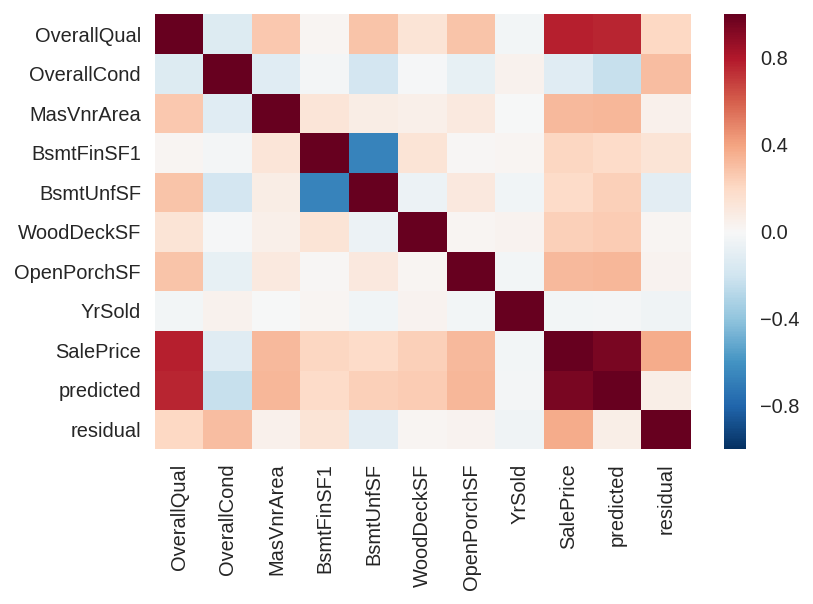

In [1015]:
#heatmap to see if there is any obvious correlation, OverallQual, OverallCond, BsmtFinSF1,BMstUnSF all seem to have
#something interesting there

sns.heatmap(renovatable.corr())

In [1016]:
#get dummies for fixed features to do the prediction on price.
fixed_predict = pd.get_dummies(fixed, columns = [
'Utilities',
'MSSubClass',
'MSZoning',
'Street',
'Alley',
'LotShape',
'LandContour',
'LotConfig',
'Neighborhood',
'Condition1',
'Condition2',
'BldgType',
'HouseStyle',
'YearBuilt', 
'YearRemodAdd',
'RoofStyle',
'Foundation',
'BsmtQual',
'BsmtExposure',
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'Fireplaces',
'GarageType',
'GarageYrBlt',
'GarageCars',
'MoSold',
'YrSold',
'SaleType',
'SaleCondition'

])
fixed_predict.drop(['SalePrice'], axis = 1, inplace = True)


In [1017]:
print(fixed_predict.shape)
print(renovatable.shape)

(1184, 463)
(1184, 30)


In [1018]:
#predict price
renovatable['predicted']=gbr_gs.predict(fixed_predict)

In [1019]:
#get the residualss
renovatable['residual']= renovatable['SalePrice']-renovatable['predicted'].round(decimals = 0)


In [1020]:
renovatable.head()

,OverallQual,OverallCond,RoofMatl,MasVnrArea,ExterQual,ExterCond,Exterior1st,Exterior2nd,MasVnrType,BsmtCond,...,GarageFinish,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,YrSold,SalePrice,predicted,residual
0,7,5,CompShg,196.0,Gd,TA,VinylSd,VinylSd,BrkFace,TA,...,RFn,TA,TA,Y,0,61,2008,208500,197245.518462,11254.0
1,6,8,CompShg,0.0,TA,TA,MetalSd,MetalSd,None,TA,...,RFn,TA,TA,Y,298,0,2007,181500,170697.088342,10803.0
2,7,5,CompShg,162.0,Gd,TA,VinylSd,VinylSd,BrkFace,TA,...,RFn,TA,TA,Y,0,42,2008,223500,220206.486365,3294.0
3,7,5,CompShg,0.0,TA,TA,Wd Sdng,Wd Shng,None,Gd,...,Unf,TA,TA,Y,0,35,2006,140000,162992.319280,-22992.0
4,8,5,CompShg,350.0,Gd,TA,VinylSd,VinylSd,BrkFace,TA,...,RFn,TA,TA,Y,192,84,2008,250000,270598.707277,-20599.0


In [1021]:
Renovatable_features_d = [
'OverallQual',
'OverallCond',
'RoofMatl',
'ExterQual',
'ExterCond',
'Exterior1st',
'Exterior2nd',
'MasVnrType',
'BsmtCond',
'BsmtFinType1',
'BsmtFinType2',
'Heating',
'HeatingQC',
'CentralAir',
'Electrical',
'KitchenQual',
'Functional',
'GarageFinish',
'GarageQual',
'GarageCond',
'PavedDrive'
]

In [1022]:
renovatable_continuous =[
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtUnfSF',
    'WoodDeckSF',
    'OpenPorchSF',
    'SalePrice'
]

In [1023]:
#get dummies for renovatable features dataframe
renovatable = pd.get_dummies(renovatable, columns = Renovatable_features_d)


In [1024]:
renovatable['residual'].describe()

count     1184.000000
mean      -104.895270
std      15019.862645
min     -79206.000000
25%      -9566.250000
50%        350.500000
75%       8851.000000
max      62907.000000
Name: residual, dtype: float64

In [1025]:
#separate dataframe into training and test set

mask = renovatable['YrSold']==2010
renovatable_train = pd.DataFrame(renovatable[~mask])
renovatable_test = pd.DataFrame(renovatable[mask])
renovatable_y_train = renovatable_train['residual']
renovatable_y_test = renovatable_test['residual']
print(renovatable_train.shape)
print(renovatable_y_train.shape)
print(renovatable_test.shape)
print(renovatable_y_test.shape)

(1044, 135)
(1044,)
(140, 135)
(140,)


In [1026]:
#drop renovatable and YrSold columns from DataFrame since I only wanted it for doing the heatmap
renovatable_test.drop(['YrSold','SalePrice', 'predicted','residual'], axis = 1, inplace = True)
renovatable_train.drop(['YrSold', 'SalePrice','predicted','residual'], axis = 1, inplace = True)

In [1027]:

pd.set_option('max_info_columns',250)

In [1028]:
pipe2 = Pipeline([
    ('skb', SelectKBest(score_func=f_regression)),
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(ElasticNet())),
    ('gbr', GradientBoostingRegressor())
    #('dcr', DecisionTreeRegressor())
   # ('lso', Lasso())
])

In [1029]:
params2 = {
    'skb__k':[40,50,60],
    #'sfm__estimator':[ElasticNet(alpha,l1_ratio)  for alpha in [1,3,5,7,] for l1_ratio in [.7,.9,1]],
    'gbr__n_estimators':[250,300,350,400],
    'gbr__learning_rate':[.03,.05,.1,.5],
    'gbr__max_depth':[1,2,3,4]
    #'dcr__max_depth':[3,4,5,7,9,10]
    #'lso__alpha':[.5,.6,.7,.8,.9,1],
    #'lso__warm_start':[False,True]
    
   
}


In [1030]:
gbr_gs2 = GridSearchCV(pipe2,
                      params2,
                      cv=ShuffleSplit(n_splits=5, random_state=42),
                      n_jobs= -1
                     )

In [1031]:
gbr_gs2.fit(renovatable_train, renovatable_y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('skb', SelectKBest(k=10, score_func=<function f_regression at 0x7faa07597f28>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, ...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'skb__k': [40, 50, 60], 'gbr__n_estimators': [250, 300, 350, 400], 'gbr__learning_rate': [0.03, 0.05, 0.1, 0.5], 'gbr__max_depth': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [1032]:
gbr_gs2.best_params_

{'gbr__learning_rate': 0.1,
 'gbr__max_depth': 1,
 'gbr__n_estimators': 300,
 'skb__k': 60}

In [1033]:
gbr_gs2.score(renovatable_train, renovatable_y_train)

0.29170933523424791

In [1034]:
gbr_gs2.score(renovatable_test,renovatable_y_test)

0.17381962674168872

In [1035]:
gs_df = pd.DataFrame(list(zip(renovatable_train.columns,gbr_gs2.best_estimator_.named_steps['gbr'].feature_importances_)))

In [ ]:
#got a R2 score of .173 which means that only approximately 17% of the variance in the residual is explainable 
#by these renovatable features.  
#looking at feature importance from the model, the most important feature are 
#"BsmtFinSF1, "MasnVnrArea", "WoodDeckSF", "OverallQual", "BsmtUnfSF",'OpenPorchSF'


In [1036]:
gs_df.sort_values([1], ascending = False).head(100)

,0,1
1,BsmtFinSF1,0.170000
0,MasVnrArea,0.090000
3,WoodDeckSF,0.080000
7,OverallQual_3,0.070000
2,BsmtUnfSF,0.063333
5,OverallQual_1,0.050000
12,OverallQual_8,0.050000
4,OpenPorchSF,0.046667
8,OverallQual_4,0.040000
9,OverallQual_5,0.040000


In [1037]:
#setting up my dataframe to see if I can compare actual saleprice and predicted saleprice and residual
renovatable_y = renovatable['residual']
renovatable2 = renovatable.drop(['YrSold','SalePrice', 'predicted','residual'], axis = 1)


In [1038]:
renovatable['predict']= gbr_gs2.predict(renovatable2)

In [754]:
#renovatable['residual']= renovatable_y

In [1039]:
renovatable['residual_diff']= renovatable['residual']- renovatable['predict']

In [1042]:
#checking actual saleprice of houses with finished basement, wood deck, open porch against saleprice of houses
#without those features.  There is a Mean price difference of $47580 which is quite a big amount considering mean
#salesprice.

renovatable_mask1 = (renovatable['BsmtFinSF1'] > 0) & \
 (renovatable['WoodDeckSF'] > 0) & (renovatable['OpenPorchSF'] > 0 )

renovatable[renovatable_mask1][['SalePrice','residual']].describe() 

,SalePrice,residual
count,210.000000,210.000000
mean,204153.109524,3023.457143
std,44115.814122,15471.198152
min,110500.000000,-46601.000000
25%,174100.000000,-8195.250000
50%,200500.000000,2485.000000
75%,234250.000000,13619.750000
max,297000.000000,45863.000000


In [1043]:
renovatable[~renovatable_mask1][['SalePrice','residual']].describe()

,SalePrice,residual
count,974.000000,974.000000
mean,156573.809035,-779.386037
std,46254.947961,14842.658264
min,37900.000000,-79206.000000
25%,126625.000000,-9622.750000
50%,148000.000000,-143.000000
75%,180000.000000,7989.750000
max,295493.000000,62907.000000


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
#### Tried an oversampling technique to try to make the dataset more balanced but was not able to get better than a .27 specificity(TN/(TN+FP) since the classification is 1 = normal sale, 0 = abnormal sale.  I don't  think any of these features are good predictors of abnormal sale and would not be comfortable using this model to attempt to predict abnormal sale.
#### Also, if I try to remove any features the results become even worse so not able to remove any features.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [1070]:
#!pip install imblearn

    100% |████████████████████████████████| 92kB 1.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for imbalanced-learn ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/b8/20/bd/0b775f7e5d413ac72562b1a5126598bcb6e0eae10da659be9f
Successfully built imbalanced-learn


In [74]:
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelBinarizer

In [75]:
#starting dataframe is "residential"



In [76]:
residential.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotSF
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1710
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1262
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1786
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,1717
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,2198


In [77]:
#get only normal and abnormal sales
mask = (residential['SaleCondition'] == 'Normal') | (residential['SaleCondition']=='Abnorml')
q3_df = pd.DataFrame(residential[mask])
q3_df.shape

(1081, 82)

In [78]:
#drop columns I don't intend to use to make predictions
q3_df.drop(['MiscFeature','Fence','PoolQC','FireplaceQu','MiscVal'], axis = 1, inplace = True)

In [79]:
q3_df.shape

(1081, 77)

In [80]:
q3_df['SaleCondition'].value_counts()

Normal     1002
Abnorml      79
Name: SaleCondition, dtype: int64

In [81]:
#normal = 1, abnormal = 0
lb = LabelBinarizer()
y = q3_df['SaleCondition']
y = lb.fit_transform(y)


In [82]:
X = q3_df.drop(['Id','Utilities','PoolArea','SaleCondition','SalePrice','SaleType','YrSold'],axis = 1)

In [83]:
categorical_list = [
    'MSSubClass', 
    'MSZoning', 
    'Street', 
    'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1',  'BsmtFinType2', 
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
         'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars',  'GarageQual',
       'GarageCond', 'PavedDrive', 
        'MoSold'
]

In [84]:
X = pd.get_dummies(X, columns = categorical_list)

In [85]:
#split my data before resampling so I don't inadvertenly bleed data from validation set to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [86]:
temp1 = pd.DataFrame(y_train)
print(temp1[0].value_counts())
temp2 = pd.DataFrame(y_test)
temp2[0].value_counts()

1    676
0     48
Name: 0, dtype: int64


1    326
0     31
Name: 0, dtype: int64

In [87]:
#highly imbalanced classes.  Try oversampling since dataset is small
ada = ADASYN()
X_resampled, y_resampled = ada.fit_sample(X_train, y_train)


In [88]:
X_resampled = pd.DataFrame(X_resampled)

In [89]:
X_resampled.columns = X.columns

In [90]:
ytemp = pd.DataFrame(y_resampled)
ytemp[0].value_counts()

0    678
1    676
Name: 0, dtype: int64

In [102]:
pipe3 = Pipeline([
   # ('skb', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    #('sfm', SelectFromModel(ElasticNet())),
    ('gbr', GradientBoostingClassifier())
    #('dcr', DecisionTreeRegressor())
   # ('lso', Lasso())
])

In [103]:
params3 = {
    #'skb__k':[40,50,60],
    #'sfm__estimator':[ElasticNet(alpha,l1_ratio)  for alpha in [1,3,5,7,] for l1_ratio in [.7,.9,1]],
    'gbr__n_estimators':[250,300,350],
    'gbr__learning_rate':[.03,.05,.1,.5],
    'gbr__max_depth':[1,2,3,4]
    #'dcr__max_depth':[3,4,5,7,9,10]
    #'lso__alpha':[.5,.6,.7,.8,.9,1],
    #'lso__warm_start':[False,True]
    
   
}


In [104]:
gbr_gs3 = GridSearchCV(pipe3,
                      params3,
                      cv=ShuffleSplit(n_splits=5, random_state=42),
                      n_jobs= -1
                     )

In [105]:
gbr_gs3.fit(X_resampled, y_resampled)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbr', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1...=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gbr__n_estimators': [250, 300, 350], 'gbr__learning_rate': [0.03, 0.05, 0.1, 0.5], 'gbr__max_depth': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [106]:
gbr_gs3.best_estimator_

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbr', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=...=350, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))])

In [107]:
gbr_gs3.best_params_

{'gbr__learning_rate': 0.03, 'gbr__max_depth': 4, 'gbr__n_estimators': 350}

In [108]:
gbr_gs3.score(X_resampled, y_resampled)

0.98079763663220088

In [109]:
gbr_gs3.score(X_test, y_test)

0.91036414565826329

In [110]:
gbr_gs3.score(X,y)

0.94634597594819614

In [111]:
y_predict = gbr_gs3.predict(X)

In [112]:
tn, fp, fn, tp = confusion_matrix(y, y_predict).ravel()
tn,fp,fn,tp

(22, 57, 1, 1001)

In [113]:
#Accuracy = (TP+TN)/(TP+TN+FP+FN)
#Specificity = TN/(TN+FP)
accuracy = (tp+tn)/(tp+tn+fp+fn)
print('accuracy: {}'.format(accuracy))
specificity = tn/(tn+fp)
print('specificiy: {}'.format(specificity))

accuracy: 0.9463459759481961
specificiy: 0.27848101265822783


In [114]:
gs3_df = pd.DataFrame(list(zip(X_resampled.columns,gbr_gs3.best_estimator_.named_steps['gbr'].feature_importances_)))

In [115]:
gs3_df.sort_values([1], ascending = False).head(100)

,0,1
2,BsmtFinSF1,0.043464
1,LotArea,0.041018
121,OverallCond_5,0.030454
53,LotConfig_Inside,0.029513
10,GarageArea,0.028721
618,HeatingQC_Ex,0.027861
4,BsmtUnfSF,0.026412
114,OverallQual_7,0.024047
6,1stFlrSF,0.023412
645,BedroomAbvGr_3,0.023128
